# Lecture 25 : Global Atomic Operations

# Example 1 : An Alternating Sum

Consider the problem of calculating the alternating sum
$$S = \sum_{i=1}^N (-1)^{i+1} i$$
For example, if $N = 5$ we get
$$S = 1 - 2 + 3 - 4 + 5 = 3$$
The exact value of $S$ depends on whether $N$ is even or odd.  
* If $N$ is even, we have that
$$S = \sum_{i=1}^N (-1)^{i+1} i = -N/2$$
* If $N$ is odd, we have that
$$S = \sum_{i=1}^N (-1)^{i+1} i = (N+1)/2$$

Exercise: Prove these formulas.

Here is some CUDA code to compute $S$ that uses a single thread block.    

In [1]:
%%writefile gpu_alt_sum_v1.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>

typedef long long int int64;

__global__ void sumKernel(int64 N) {

    __shared__ int64 sum;

    int thread_num = threadIdx.x;
    int num_threads = blockDim.x;

    /* initialize sum to 0 */
    if (thread_num == 0) {
        sum = 0;
    }
    __syncthreads();

    /* calculate the thread sum */
    int64 thread_sum = 0;
    for (int64 i = 1+thread_num; i <= N;i+=num_threads) {
        if (i % 2 == 0) {
            thread_sum -= i;
        } else {
            thread_sum += i;
        }
    }
    /* CUDA only supports unsigned long long int atomicAdd */
    /* Fortunately, Signed and unsigned add give bit-identical results. */
    /* The difference is only how the result is interpreted. */
    atomicAdd((unsigned long long*)&sum,(unsigned long long)thread_sum);
    __syncthreads();

    /* thread 0 prints the sum */
    if (thread_num == 0) {
        printf ("sum = %lld\n",sum);
    }
}

int main (int argc, char** argv) {

    /* get N and num_threads from the command line */
    if (argc < 3) {
        printf ("Command usage : %s %s %s\n",argv[0],"N","num_threads");
        return 1;
    }
    int64 N = atol(argv[1]);
    int num_threads = atoi(argv[2]);
    printf ("number of threads = %d\n",num_threads);
    int64 correct_sum;
    if (N % 2 == 0) {
        correct_sum = -N/2;
    } else {
        correct_sum = (N+1)/2;
    }
    printf ("correct sum = %lld\n",correct_sum);

    /* launch kernel */
    sumKernel <<< 1, num_threads >>> (N);
    cudaDeviceSynchronize();

}

Writing gpu_alt_sum_v1.cu


In [2]:
!nvcc -arch=sm_75 -o gpu_alt_sum_v1 gpu_alt_sum_v1.cu

In [6]:
!time ./gpu_alt_sum_v1 2000000000 128

number of threads = 128
correct sum = -1000000000

real	0m0.002s
user	0m0.000s
sys	0m0.002s


### Discussion: What is the downside of using a single thread block?

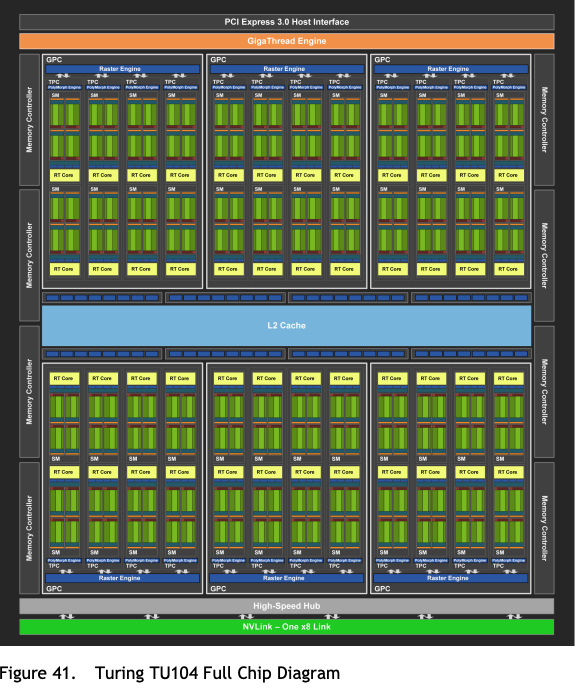

# Example 2 : Using the Full GPU (first attempt)

Discussion: What is the minimal amount of work we can have each thread do?

Here is a partially completed CUDA code for our first full GPU solution.  

Complete the code in class.  A full solution is given below.

In [12]:
%%writefile gpu_alt_sum_v2.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>

typedef long long int int64;

__global__ void sumKernel(int64 N, int64* sum) {

}

int main (int argc, char** argv) {

    /* get N and B from the command line */
    /* B is the number of threads per block */
    /* we typically choose B to be a multiple of 32 */
    /* the maximum value of B is 1024 */
    if (argc < 3) {
        printf ("Command usage : %s %s %s\n",argv[0],"N","B");
        return 1;
    }
    int64 N = atol(argv[1]);
    int B = atoi(argv[2]);

    /* G is the number of thread blocks */
    /* the maximum number of thread blocks G is 2^31 - 1 = 2147483647 */
    /* We choose G to be the minimum number of thread blocks to have at least N threads */

    /* add code here to compute G */
    int G = 0;

    printf ("N = %lld\n",N);
    printf ("threads per block B = %d\n",B);
    printf ("number of thread blocks G = %d\n",G);
    printf ("number of threads G*B = %d\n",G*B);
    int64 correct_sum;
    if (N % 2 == 0) {
        correct_sum = -N/2;
    } else {
        correct_sum = (N+1)/2;
    }
    printf ("correct sum = %lld\n",correct_sum);

    /* the sum in host memory */
    int64 sum = 0;

    /* add code here */

    /* output the results */
    printf ("sum = %lld\n",sum);

}

Overwriting gpu_alt_sum_v2.cu


In [13]:
!nvcc -arch=sm_75 -o gpu_alt_sum_v2 gpu_alt_sum_v2.cu

In [14]:
!time ./gpu_alt_sum_v2 2000000000 128

N = 2000000000
threads per block B = 128
number of thread blocks G = 0
number of threads G*B = 0
correct sum = -1000000000
sum = 0

real	0m0.002s
user	0m0.000s
sys	0m0.001s


# Example 2 : Solution

In [10]:
%%writefile gpu_alt_sum_v2.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>

typedef long long int int64;

__global__ void sumKernel(int64 N, int64* sum) {

    int thread_num = blockIdx.x*blockDim.x + threadIdx.x;
    if (thread_num < N) {
        int64 term = thread_num+1;
        if (term % 2 == 0) {
            term *= -1;
        }
        atomicAdd((unsigned long long*)sum,(unsigned long long)term);
    }
}

int main (int argc, char** argv) {

    /* get N and B from the command line */
    /* B is the number of threads per block */
    /* we typically choose B to be a multiple of 32 */
    /* the maximum value of B is 1024 */
    if (argc < 3) {
        printf ("Command usage : %s %s %s\n",argv[0],"N","B");
        return 1;
    }
    int64 N = atol(argv[1]);
    int B = atoi(argv[2]);

    /* G is the number of thread blocks */
    /* the maximum number of thread blocks G is 2^31 - 1 = 2147483647 */
    /* We choose G to be the minimum number of thread blocks to have at least N threads */
    int G = (N+B-1)/B;
    printf ("N = %lld\n",N);
    printf ("threads per block B = %d\n",B);
    printf ("number of thread blocks G = %d\n",G);
    printf ("number of threads G*B = %d\n",G*B);
    int64 correct_sum;
    if (N % 2 == 0) {
        correct_sum = -N/2;
    } else {
        correct_sum = (N+1)/2;
    }
    printf ("correct sum = %lld\n",correct_sum);

    /* the sum in host memory */
    int64 sum;

    /* the sum in device memory */
    int64* d_sum;
    cudaMalloc (&d_sum,sizeof(int64));

    /* initialize the device sum to 0 */
    cudaMemset (d_sum,0,sizeof(int64));

    /* launch kernel */
    sumKernel <<< G, B >>> (N,d_sum);

    /* copy total stopping time data from device to host */
    cudaMemcpy (&sum, d_sum, sizeof(int64),cudaMemcpyDeviceToHost);

    /* output the results */
    printf ("sum = %lld\n",sum);

    /* free the memory on the device */
    cudaFree (d_sum);
}

Overwriting gpu_alt_sum_v2.cu


In [11]:
!nvcc -arch=sm_75 -o gpu_alt_sum_v2 gpu_alt_sum_v2.cu

In [9]:
!time ./gpu_alt_sum_v2 2000000000 128

N = 2000000000
threads per block B = 128
number of thread blocks G = 15625000
number of threads G*B = 2000000000
correct sum = -1000000000
sum = 0

real	0m0.002s
user	0m0.000s
sys	0m0.002s


# Discussion : Our first attempt at using the full GPU results in a slower code!  What is the primary problem of our first attempt?

# Example 3 : Using the Full GPU (second attempt)

Discussion: How can we overcome the problems with our first attempt?

Here is a partially completed CUDA code for our second full GPU solution.  

Complete the code in class.  A full solution is given below.

To let the GPU stretch its legs a bit you will have to crank $N$ to 1 trillion for this version!

In [36]:
%%writefile gpu_alt_sum_v3.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>

typedef long long int int64;

__global__ void sumKernel(int64 N, int64 T, int64* sum) {

    int thread_num = blockIdx.x*blockDim.x + threadIdx.x;

    /* calculate the sum */
    int64 thread_sum = 0;

    /* add a loop here */
    /*
        if (i % 2 == 0) {
            thread_sum -= i;
        } else {
            thread_sum += i;
        }
    */

    /* add the thread sum to the global sum */
    atomicAdd((unsigned long long*)sum,(unsigned long long)thread_sum);
}

int main (int argc, char** argv) {

    /* get N, T, and B from the command line */
    /* T is the number of terms per thread */
    /* B is the number of threads per block */
    /* we typically choose B to be a multiple of 32 */
    /* the maximum value of B is 1024 */
    if (argc < 4) {
        printf ("Command usage : %s %s %s %s\n",argv[0],"N","T","B");
        return 1;
    }
    int64 N = atol(argv[1]);
    int64 T = atol(argv[2]);
    int B = atoi(argv[3]);

    /* G is the number of thread blocks */
    /* the maximum number of thread blocks G is 2^31 - 1 = 2147483647 */
    /* We choose G to be the minimum number of thread blocks to have at least N/T threads */

    /* add code here to compute G */
    int G = 0;

    printf ("N = %lld\n",N);
    printf ("terms per thread T = %lld\n",T);
    printf ("threads per block B = %d\n",B);
    printf ("number of thread blocks G = %d\n",G);
    printf ("number of threads G*B = %d\n",G*B);
    int64 correct_sum;
    if (N % 2 == 0) {
        correct_sum = -N/2;
    } else {
        correct_sum = (N+1)/2;
    }
    printf ("correct sum = %lld\n",correct_sum);

    /* the sum in host memory */
    int64 sum;

    /* the sum in device memory */
    int64* d_sum;
    cudaMalloc (&d_sum,sizeof(int64));

    /* initialize the device sum to 0 */
    cudaMemset (d_sum,0,sizeof(int64));

    /* launch kernel */
    sumKernel <<< G, B >>> (N,T,d_sum);

    /* copy total stopping time data from device to host */
    cudaMemcpy (&sum, d_sum, sizeof(int64),cudaMemcpyDeviceToHost);

    /* output the results */
    printf ("sum = %lld\n",sum);

    /* free the memory on the device */
    cudaFree (d_sum);
}

Overwriting gpu_alt_sum_v3.cu


In [37]:
!nvcc -arch=sm_75 -o gpu_alt_sum_v3 gpu_alt_sum_v3.cu

gpu_alt_sum_v3.cu(9): warning #177-D: variable "thread_num" was declared but never referenced



In [38]:
!time ./gpu_alt_sum_v3 2000000000 1000 128

N = 2000000000
terms per thread T = 1000
threads per block B = 128
number of thread blocks G = 0
number of threads G*B = 0
correct sum = -1000000000
sum = 4294967424

real	0m0.004s
user	0m0.000s
sys	0m0.002s


# Example 3 : Solution

In [20]:
%%writefile gpu_alt_sum_v3.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>

typedef long long int int64;

__global__ void sumKernel(int64 N, int64 T, int64* sum) {

    int thread_num = blockIdx.x*blockDim.x + threadIdx.x;

    /* calculate the sum */
    int64 thread_sum = 0;
    int64 start = thread_num*T;
    int64 end = start+T;
    if (end > N) {
        end = N;
    }
    for (int64 i = start+1; i <= end;i++) {
        if (i % 2 == 0) {
            thread_sum -= i;
        } else {
            thread_sum += i;
        }
    }

    atomicAdd((unsigned long long*)sum,(unsigned long long)thread_sum);
}

int main (int argc, char** argv) {

    /* get N, T, and B from the command line */
    /* T is the number of terms per thread */
    /* B is the number of threads per block */
    /* we typically choose B to be a multiple of 32 */
    /* the maximum value of B is 1024 */
    if (argc < 4) {
        printf ("Command usage : %s %s %s %s\n",argv[0],"N","T","B");
        return 1;
    }
    int64 N = atol(argv[1]);
    int64 T = atol(argv[2]);
    int B = atoi(argv[3]);

    /* G is the number of thread blocks */
    /* the maximum number of thread blocks G is 2^31 - 1 = 2147483647 */
    /* We choose G to be the minimum number of thread blocks to have at least N/T threads */
    int G = (N+B*T-1)/(B*T);
    printf ("N = %lld\n",N);
    printf ("terms per thread T = %lld\n",T);
    printf ("threads per block B = %d\n",B);
    printf ("number of thread blocks G = %d\n",G);
    printf ("number of threads G*B = %d\n",G*B);
    int64 correct_sum;
    if (N % 2 == 0) {
        correct_sum = -N/2;
    } else {
        correct_sum = (N+1)/2;
    }
    printf ("correct sum = %lld\n",correct_sum);

    /* the sum in host memory */
    int64 sum;

    /* the sum in device memory */
    int64* d_sum;
    cudaMalloc (&d_sum,sizeof(int64));

    /* initialize the device sum to 0 */
    cudaMemset (d_sum,0,sizeof(int64));

    /* launch kernel */
    sumKernel <<< G, B >>> (N,T,d_sum);

    /* copy total stopping time data from device to host */
    cudaMemcpy (&sum, d_sum, sizeof(int64),cudaMemcpyDeviceToHost);

    /* output the results */
    printf ("sum = %lld\n",sum);

    /* free the memory on the device */
    cudaFree (d_sum);
}

Overwriting gpu_alt_sum_v3.cu


In [21]:
!nvcc -arch=sm_75 -o gpu_alt_sum_v3 gpu_alt_sum_v3.cu

In [23]:
!time ./gpu_alt_sum_v3 2000000000 1000 128

N = 2000000000
terms per thread T = 1000
threads per block B = 128
number of thread blocks G = 15625
number of threads G*B = 2000000
correct sum = -1000000000
sum = 4294967424

real	0m0.003s
user	0m0.000s
sys	0m0.002s


# Class Exercise: The standard deviation of the numbers $1 ... N$ is given by
$$\sigma = \sqrt{\frac{N^2-1}{12}}$$

A sequential code to compute the standard deviation of the numbers
$1 ... N$ is given below.  

Begin to write an efficient CUDA implementation that uses the techniques developed in this lecture.   

Hint: You will need to use two separate CUDA kernels!

In [45]:
%%writefile std_dev.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>

typedef unsigned long long int uint64;

int main (int argc, char** argv) {

    /* get N from the command line */
    if (argc < 2) {
        printf ("Command usage : %s %s\n",argv[0],"N");
        return 1;
    }
    uint64 N = atol(argv[1]);

    /* compute the mean */
    uint64 sum = 0;
    for (uint64 i=1;i<=N;i++) {
        sum += i;
    }
    double mean = 1.0*sum/N;

    /* compute the variance */
    double sum_diff_sq = 0;
    for (uint64 i=1;i<=N;i++) {
        sum_diff_sq += (i-mean)*(i-mean);
    }
    double variance = sum_diff_sq/N;

    /* compute the standard deviation */
    double std_dev = sqrt(variance);

    /* print the results */
    printf ("computed std dev is %.1lf, sqrt((N^2-1)/12) is %.1lf\n",std_dev,sqrt((N*N-1)/12.0));

}


Overwriting std_dev.c


In [46]:
!gcc -o std_dev std_dev.c -lm

In [47]:
!time ./std_dev 100000000

computed std dev is 28867513.5, sqrt((N^2-1)/12) is 28867513.5

real	0m0.679s
user	0m0.660s
sys	0m0.004s
